# Image generation

### Setup

In [208]:
%matplotlib inline
import importlib

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [209]:
import utils2; importlib.reload(utils2)
from utils2 import *
from keras import metrics
from vgg16_avg import VGG16_Avg

In [210]:
limit_mem()

In [359]:
import myutils; importlib.reload(myutils)
from myutils import *

def style_loss(x, targ): 
    return metrics.mse(gram_matrix(x), gram_matrix(targ))

def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def blurify(x):
    x = x.reshape((1, 300, 300, 3))
    for k in range(3):
        x[:,:,:,k] = scipy.ndimage.filters.gaussian_filter(x[:,:,:,k], 1)
    return x

def solve_image(eval_obj, niter, x, path=None):
    last_min_val = 1000 # start from an arbitrary number
    loss_history = {}
    shp = x.shape
    imagenet_mean = [123.68, 116.779, 103.939]
    rn_mean = np.array((imagenet_mean), dtype=np.float32) 
    deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        #print(('Iter:{}, loss:{}').format(i , min_val))     
        if abs(last_min_val - min_val)< 0.1:
            x = blurify(x)
            #print ('Blurify')
        last_min_val = min_val 
        loss_history[i] = min_val        
        #imsave(f'{path}/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
        img =(deproc(x.copy(), shp)[0])
        imsave(path+'/res_at_iteration_%d.png' %(i), img)
    return x, loss_history
def style_loss(x, targ): 
    return metrics.mse(gram_matrix(x), gram_matrix(targ))
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

### Load images

In [293]:
merge_result_path = '/home/ubuntu/nbs/data/results/toddlerart/craftowl/familybnw/'
content_result_path = '/home/ubuntu/data/results/cafesociety/contents'
style_result_path = '/home/ubuntu/nbs/data/results/cafesociety/styles'
content_path = '/home/ubuntu/nbs/data/content/familybnw.jpg'
style_path = '/home/ubuntu/nbs/data/style/toddler/craftowl.JPG'

In [294]:
import myutils; importlib.reload(myutils)
from myutils import *

In [295]:
image_size = (300, 300)

In [296]:
image_size[0]

300

In [297]:
#content_path = '/Users/xinxin/projectnotes/toddlerartist/song/bodycalm.jpg'

In [298]:
#style_path = '/Users/xinxin/projectnotes/toddlerartist/style/flowerplate.jpg'

In [299]:
img_arr = get_content(image_size, content_path)

In [300]:
style_arr = get_style(image_size, style_path)

In [301]:
#Uncomment this code if you want to create tile style images
tile_size = (40, 50)
style_arr = get_style_tile(image_size, tile_size, style_path)

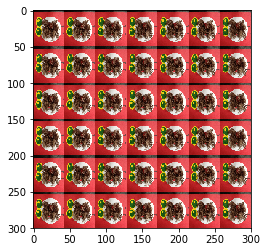

In [302]:
plot_arr(style_arr)

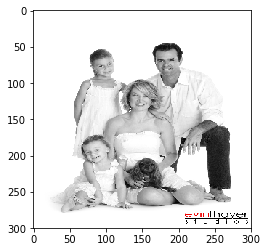

In [303]:
plot_arr(img_arr)

### content model

In [349]:
model = VGG16_Avg(include_top=False)
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)

function_input = [model.input]
function_output = ([loss]+grads)
fn = K.function(function_input, function_output)
evaluator = Evaluator(fn, img_arr.shape)

In [352]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(img_arr.shape)
content_iterations=5
x_final, content_loss_history = solve_image(evaluator, content_iterations, x, path = merge_result_path)

### content model results

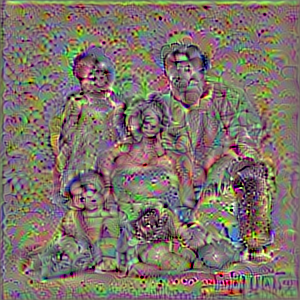

In [336]:
Image.open(merge_result_path + '/res_at_iteration_4.png')

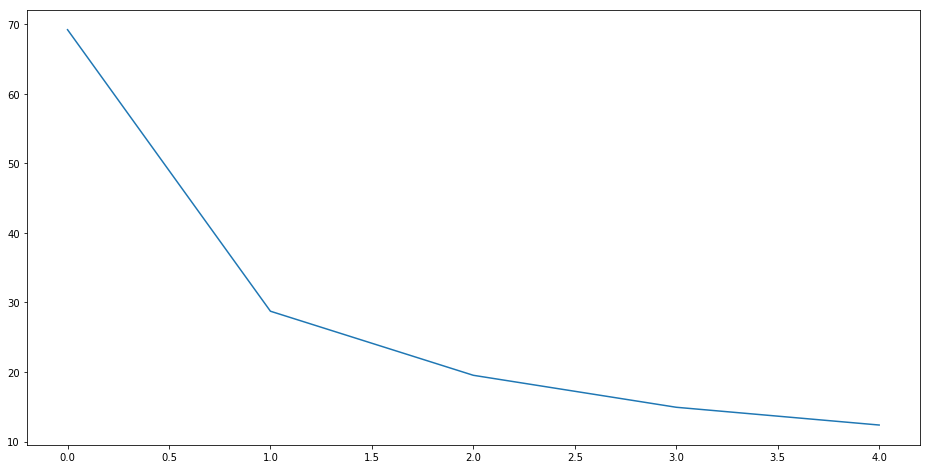

In [369]:
plt.figure(figsize=(16,8))
plt.plot([content_loss_history[i] for i in range(content_iterations)])

### style model

In [357]:
input_shape = style_arr.shape[1:]

In [358]:
model = VGG16_Avg(include_top=False, input_shape=input_shape)
outputs = {l.name: l.output for l in model.layers}
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,4)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [362]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)

function_input = [model.input]
function_output = ([loss]+grads)
style_fn = K.function(function_input, function_output)
evaluator = Evaluator(style_fn, style_arr.shape)

In [363]:
style_iterations=10
x = rand_img(shp)
x, style_loss_history = solve_image(evaluator, style_iterations, x, merge_result_path)

### style model results

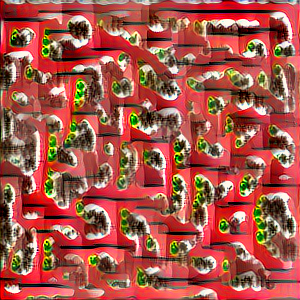

In [371]:
Image.open(merge_result_path + '/res_at_iteration_9.png')

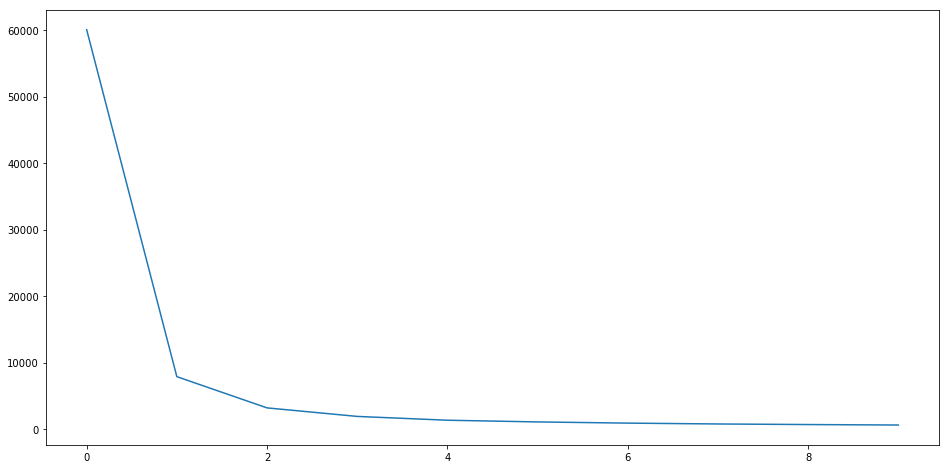

In [372]:
plt.figure(figsize=(16,8))
plt.plot([style_loss_history[i] for i in range(style_iterations)])

### Style transfer

In [373]:
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
content_layer = outputs['block3_conv2']
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(img_arr))

In [374]:
alpha = 1.0
beta = 10.0
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, style_targs))
loss = alpha*loss +beta* metrics.mse(content_layer, content_targ)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(transfer_fn, shp)

In [375]:
merge_iterations=10
x = rand_img(shp)
x, merge_loss_history = solve_image(evaluator, merge_iterations, x, merge_result_path)

### merge model results

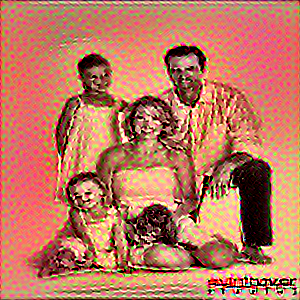

In [376]:
Image.open(merge_result_path + '/res_at_iteration_9.png')

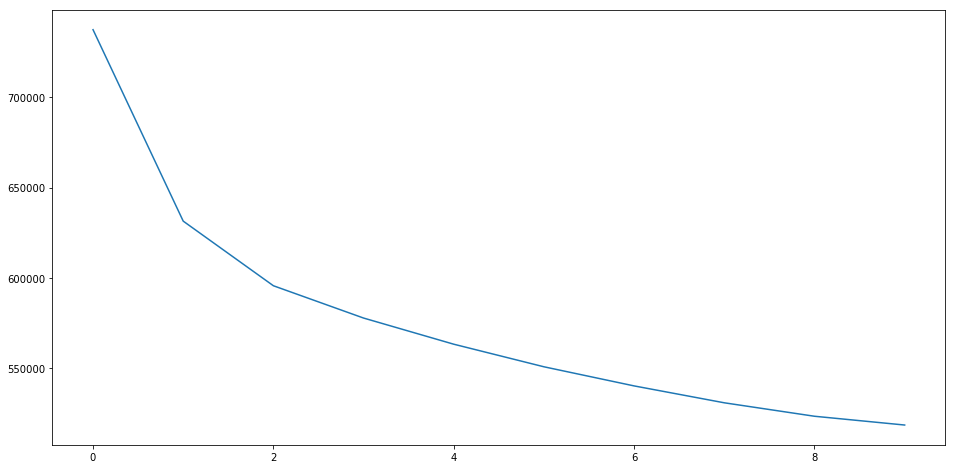

In [377]:
plt.figure(figsize=(16,8))
plt.plot([merge_loss_history[i] for i in range(merge_iterations)])

These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .

## Use content loss to create a super-resolution network

So far we've demonstrated how to achieve succesful results in style transfer. However, there is an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible method for any sort of real-time application. Fortunately we can adress this issue by using a fully convolutional network (FCN), and in particular we'll look at this implementation for Super resolution. We are following the approach in [this paper](https://arxiv.org/abs/1603.08155).

In [285]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]

To start we'll define some of the building blocks of our network. In particular recall the residual block (as used in [Resnet](https://arxiv.org/abs/1512.03385)), which is just a sequence of 2 convolutional layers that is added to the initial block input. We also have a de-convolutional layer (also known as a "transposed convolution" or "fractionally strided convolution"), whose purpose is to learn to "undo" the convolutional function. It does this by padding the smaller image in such a way to apply filters on it to produce a larger image.

In [65]:
def conv_block(x, filters, size, stride=(2,2), mode='same'):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(axis=1, mode=2)(x)
    return Activation('relu')(x)

In [70]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = Convolution2D(nf, 3, 3, border_mode='same')(x)
    x = BatchNormalization(axis=1, mode=2)(x)
    return merge([x, ip], mode='sum')

In [71]:
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride, border_mode='same',
                        output_shape=(None,)+shape)(x)
    x = BatchNormalization(axis=1, mode=2)(x)
    return Activation('relu')(x)

In [72]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

This model here is using the previously defined blocks to encode a low resolution image and then upsample it to match the same image in high resolution.

In [97]:
inp=Input(inp_shape)
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=deconv_block(x, 64, 3, (144, 144, 64))
x=deconv_block(x, 64, 3, (288, 288, 64))
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image. 

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convolutional layer in Vgg16 (which the paper refers to as "perceptual loss"). In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [98]:
vgg_l = Lambda(preproc)
outp_l = vgg_l(outp)

Since we only want to learn the "upsampling network", and are just using VGG to calculate the loss function, we set the Vgg layers to not be trainable.

In [99]:
out_shape = (288,288,3)
vgg_inp=Input(out_shape)
vgg= VGG16(include_top=False, input_tensor=vgg_l(vgg_inp))
for l in vgg.layers: l.trainable=False

In [100]:
vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

An important difference in training for super resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer). 

In [106]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1, vgg2])
m_final = Model([inp, vgg_inp], loss)
targ = np.zeros((arr.shape[0], 128))

Finally we compile this chain of models and we can pass it the original low resolution image as well as the high resolution to train on. We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a keras model.

In [107]:
m_final.compile('adam', 'mse')

In [119]:
m_final.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

KeyboardInterrupt: 

We use learning rate annealing to get a better fit.

In [123]:
K.set_value(m_final.optimizer.lr, 1e-4)
m_final.fit([arr_lr, arr_hr], targ, 16, 2, **parms)

We are only interested in the trained part of the model, which does the actual upsampling.

In [126]:
top_model = Model(inp, outp)
top_model.save_weights(dpath+'top_final.h5')

In [135]:
p = top_model.predict(arr_lr[:20])

After training for some time, we get some very impressive results! Look at these two images, we can see that the predicted higher resolution image has filled in a lot of detail, including the shadows under the greens and the texture of the food.

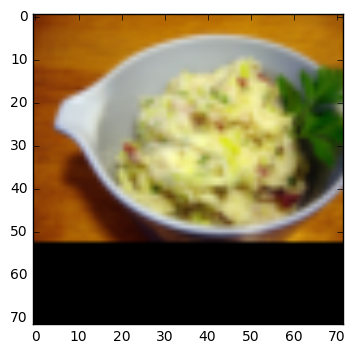

In [133]:
plt.imshow(arr_lr[10].astype('uint8'));

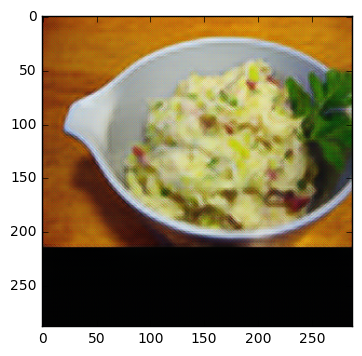

In [136]:
plt.imshow(p[10].astype('uint8'))

The important thing to take away here is that as opposed to our earlier approaches, this type of approach results in a model that can created the desired image and is a scalable implementation.

Note that we haven't used a test set here, so we don't know if the above result is due to over-fitting. As part of your homework, you should create a test set, and try to train a model that gets the best result you can on the test set.

### Fast style transfer

The original paper showing the above approach to super resolution also used this approach to create a much faster style transfer system (for a specific style). Take a look at [the paper](https://arxiv.org/abs/1603.08155) and the very helpful [supplementary material](http://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf). Your mission, should you choose to accept it, it to modify the super resolution example above to do fast style transfer based on this paper. The supplementary material mentions that that found reflection padding helpful - we have implemented this as a keras layer for you. All the other layers and blocks are already defined above.

(This is also a nice simple example of a custom later that you can refer to when creating your own custom layers in the future.)

In [287]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

Testing the reflection padding layer:

In [298]:
inp = Input((288,288,3))
ref_model = Model(inp, ReflectionPadding2D((40,2))(inp))
ref_model.compile('adam', 'mse')

In [299]:
p = ref_model.predict(arr_hr[50:51])

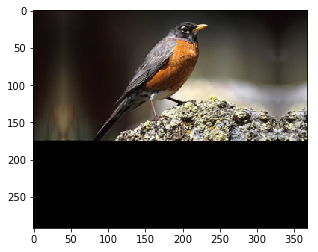

In [300]:
plt.imshow(p[0].astype('uint8'));

## Next steps

Here's some ideas for things to try:
- https://github.com/junyanz/iGAN
- https://arxiv.org/abs/1605.04603
- https://arxiv.org/abs/1606.05897
- http://cs231n.stanford.edu/reports2016/208_Report.pdf